This notebook introduces a transaction data simulator for generating legitimate and fraudulent transactions. It serves as a tool to evaluate fraud detection techniques effectively. Despite its simple design, the simulator replicates many real-world data challenges, including class imbalance, mixed features, complex relationships, and time-dependent fraud scenarios.

# Transaction Data Simulator

This simulator serves as a tool to evaluate fraud detection techniques effectively. Despite its simple design, the simulator replicates many real-world data challenges, including class imbalance, mixed features, complex relationships, and time-dependent fraud scenarios. The simulation involves 6 main steps which we will cover in-depth in this section, as illustrated in the diagram below:

![simulator](images/simulator.png)

In [27]:
import os
import numpy as np
import pandas as pd
import datetime
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
from neo4j import GraphDatabase
from tqdm.notebook import tqdm
import warnings

%matplotlib inline
pd.set_option('display.notebook_repr_html', True)
pd.DataFrame._repr_latex_ = lambda self: "\n".join([r'\begin{center}', self.to_latex(), r'\end{center}'])
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
warnings.filterwarnings('ignore')

## Customer Profiles Generation

Unique spending habits are simulated through customer attributes such as location, spending frequency, and spending amount, organized into `customer_profiles_table`. Each customer is characterized by:

- `CUSTOMER_ID`: A unique identifier for the customer.
- `(x_customer_id, y_customer_id)`: Real coordinates representing the customer's geographical location on a 100 * 100 grid.
- `(mean_amount, std_amount)`: The mean and standard deviation of transaction amounts for the customer
- `mean_nb_tx_per_day`: The average number of transactions per day for the customer

In [2]:
def generate_customer_profiles_table(n_customers, random_state=0):
    '''
    This function provides an implementation for generating a table of customer
    profiles. It takes as input the number of customers for which to generate a
    profile and a random state for reproducibility. It returns a DataFrame
    containing the properties for each customer.
    '''
    np.random.seed(random_state)
    customer_id_properties=[]

    # Generate customer properties from random distributions
    for customer_id in range(n_customers):
        x_customer_id = np.random.uniform(0,100)
        y_customer_id = np.random.uniform(0,100)
        # Arbitrary (but sensible) values
        mean_amount = np.random.uniform(5,100)
        std_amount = mean_amount/2
        mean_nb_tx_per_day = np.random.uniform(0,4)
        customer_id_properties.append([customer_id,
                                      x_customer_id, y_customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])

    customer_profiles_table = pd.DataFrame(customer_id_properties, columns= [
            'CUSTOMER_ID',
            'x_customer_id', 'y_customer_id',
            'mean_amount', 'std_amount',
            'mean_nb_tx_per_day'])
    return customer_profiles_table

In [3]:
customer_profiles_table = generate_customer_profiles_table(n_customers=5)
customer_profiles_table.rename(columns=lambda x: x.replace('_', '-'))

,CUSTOMER-ID,x-customer-id,y-customer-id,mean-amount,std-amount,mean-nb-tx-per-day
0,0,54.881350,71.518937,62.262521,31.131260,2.179533
1,1,42.365480,64.589411,46.570785,23.285393,3.567092
2,2,96.366276,38.344152,80.213879,40.106939,2.115580
3,3,56.804456,92.559664,11.748426,5.874213,0.348517
4,4,2.021840,83.261985,78.924891,39.462446,3.480049


## Terminal Profiles Generation

Terminal characteristics represented in `terminal_profiles_table`, focus solely on geographical location. Each terminal will be defined by the following properties:

- `TERMINAL_ID`: The terminal ID
- `(x_terminal_id, y_terminal_id)`: A pair of real coordinates defining the geographical location of the terminal

In [4]:
def generate_terminal_profiles_table(n_terminals, random_state=0):
    '''
    This function provides an implementation for generating a table of terminal
    profiles. It takes as input the number of terminals for which to generate a
    profile and a random state for reproducibility. It returns a DataFrame
    containing the properties for each terminal.
    '''

    np.random.seed(random_state)
    terminal_id_properties=[]
    # Generate terminal properties from random distributions
    for terminal_id in range(n_terminals):
        x_terminal_id = np.random.uniform(0,100)
        y_terminal_id = np.random.uniform(0,100)
        terminal_id_properties.append([terminal_id,
                                      x_terminal_id, y_terminal_id])

    terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=
        ['TERMINAL_ID', 'x_terminal_id', 'y_terminal_id'])
    return terminal_profiles_table

In [5]:
terminal_profiles_table = generate_terminal_profiles_table(n_terminals=5)
terminal_profiles_table.rename(columns=lambda x: x.replace('_', '-'))

,TERMINAL-ID,x-terminal-id,y-terminal-id
0,0,54.881350,71.518937
1,1,60.276338,54.488318
2,2,42.365480,64.589411
3,3,43.758721,89.177300
4,4,96.366276,38.344152


## Association of Customer Profiles to Terminals

Customers are assumed to transact only at terminals within a certain radius `r` of their geographical location, reflected in the `available_terminals` feature added to each customer profile. Comparing the terminal locations stored in `terminal_profiles_table` and the customer locations in `customer_profiles_table`, we can compute the list of available terminals for a given customer at a given radius. The plot below demonstrates how the radius can affect the inclusion of surrounding terminals.

![available_terminals](images/available_terminals.png)

In [6]:
def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):
    '''
    This function returns the list of terminals within a radius of r, given as
    input a customer profile (any row in the customer profiles table), an array
    containing the geographical location of all terminals, and the radius r.
    '''
    # Location (x,y) of customer as numpy array
    x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float)

    # Squared difference in coordinates between customer and terminal locations
    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)

    # Sum along rows and compute suared root to get distance
    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))

    # Get the indices of terminals which are at a distance less than r
    available_terminals = list(np.where(dist_x_y<r)[0])

    # Return the list of terminal IDs
    return available_terminals

Calculating the available terminals for each customer can be performed using the pandas `apply` function. The results are stored as a new column named `available_terminals` in the customer profiles table.

In [7]:
# We first get the geographical locations of all terminals as a numpy array
x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)

# Now we compute the available terminals
customer_profiles_table['available_terminals'] = \
    customer_profiles_table.apply(lambda x : \
        get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=50),
        axis=1
    )
customer_profiles_table.rename(columns=lambda x: x.replace('_', '-'))

,CUSTOMER-ID,x-customer-id,y-customer-id,mean-amount,std-amount,mean-nb-tx-per-day,available-terminals
0,0,54.881350,71.518937,62.262521,31.131260,2.179533,"[0, 1, 2, 3]"
1,1,42.365480,64.589411,46.570785,23.285393,3.567092,"[0, 1, 2, 3]"
2,2,96.366276,38.344152,80.213879,40.106939,2.115580,"[1, 4]"
3,3,56.804456,92.559664,11.748426,5.874213,0.348517,"[0, 1, 2, 3]"
4,4,2.021840,83.261985,78.924891,39.462446,3.480049,"[2, 3]"


## Generation of Transactions

Transactions are generated based on customer attributes and terminal availability, resulting in a `transactions_df` table. We have now all the necessary information to generate the transactions, using the `generate_transactions_table` function below. This function will attempt to randomly populate the transaction data starting from a given date, until a certain number of days. Most of the values will be generated randomly, yet following a normal, uniform, or Poisson distribution.

We can verify that the generated transactions comply with the customer profile properties:
- `TERMINAL_ID`s correspond to those in the list of available terminals. However, not necessarily all these available terminals will be selected. As a result, the `available_terminals` is NOT equivalent to the actual terminals to which each customer is connected.
- `TX_AMOUNT`s appear to align with the customer's amount parameters represented as `mean_amount` and `std_amount`.
- The number of transactions per day varies based on the transaction frequency parameters of the customer, i.e. `mean_nb_tx_per_day`.

In [8]:
def generate_transactions_table(customer_profile, start_date = "2018-04-01", nb_days = 10):
    '''
    takes as input a customer profile, a starting date, and a number of days for
    which to generate transactions. It will return a table of transactions
    without considering the labels
    '''
    customer_transactions = []
    random.seed(int(customer_profile.CUSTOMER_ID))
    np.random.seed(int(customer_profile.CUSTOMER_ID))

    # For all days
    for day in range(nb_days):
        # Random number of transactions for that day
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
        # If nb_tx positive, let us generate transactions
        if nb_tx>0:
            for tx in range(nb_tx):
                # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))

                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):
                    # Amount is drawn from a normal distribution
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)

                    amount=np.round(amount,decimals=2)
                    if len(customer_profile.available_terminals)>0:
                        terminal_id = random.choice(customer_profile.available_terminals)
                        customer_transactions.append([time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID,
                                                      terminal_id, amount])

    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT'])
    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    return customer_transactions

Now, let's generate transactions for all customers, which can be done straightforwardly using the pandas `groupby` and `apply` methods. This results in a set of 65 transactions, involving 5 customers, 5 terminals, and spanning across 5 days.

In [9]:
transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=5)).reset_index(drop=True)
transactions_df.rename(columns=lambda x: x.replace('_', '-')).head()

,TX-DATETIME,CUSTOMER-ID,TERMINAL-ID,TX-AMOUNT,TX-TIME-SECONDS,TX-TIME-DAYS
0,2018-04-01 07:19:05,0,3,123.59,26345,0
1,2018-04-01 19:02:02,0,3,46.51,68522,0
2,2018-04-01 18:00:16,0,0,77.34,64816,0
3,2018-04-02 15:13:02,0,2,32.35,141182,1
4,2018-04-02 14:05:38,0,3,63.30,137138,1


## Generation of Fraud Scenarios

In the final stage of the simulation, transactions are categorized as *legitimate* or *fraudulent* through the following scenarios:

- **Scenario 1:** Any transaction exceeding $220 is flagged as fraudulent. This unrealistic scenario serves as a straightforward pattern for validating basic fraud detection methods.
- **Scenario 2:** Each day, two terminals are randomly selected. Transactions made on these terminals in the subsequent 28 days are marked as fraudulent. This scenario simulates criminal exploitation of terminals, such as through phishing attacks.
- **Scenario 3:** Every day, three customers are randomly chosen. Over the next 14 days, one-third of their transactions have their amounts multiplied by 5 and are labeled as fraudulent. This simulates card-not-present fraud, where leaked customer credentials lead to higher-value transactions by fraudsters. Detection of this scenario requires tracking customer spending habits and adapting to temporary compromises, similar to scenario 2.

Notably, the initial month of the generated dataset has fewer fraudulent transactions due to scenario durations. The resulting dataset highlights class imbalance, mixes numerical and categorical features, and includes time-dependent fraud scenarios.

In [10]:
def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df):

    start_time=time.time()

    # By default, all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0

    # Scenario 1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD']=1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD_SCENARIO']=1
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))

    # Scenario 2
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        compromised_terminals = terminal_profiles_table.TERMINAL_ID.sample(n=2, random_state=day)
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) &
                                                    (transactions_df.TX_TIME_DAYS<day+28) &
                                                    (transactions_df.TERMINAL_ID.isin(compromised_terminals))]
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD']=1
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD_SCENARIO']=2
    nb_frauds_scenario_2=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_1
    print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))

    # Scenario 3
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        compromised_customers = customer_profiles_table.CUSTOMER_ID.sample(n=3, random_state=day).values
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) &
                                                    (transactions_df.TX_TIME_DAYS<day+14) &
                                                    (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
        nb_compromised_transactions=len(compromised_transactions)
        random.seed(day)
        index_fauds = random.sample(list(compromised_transactions.index.values),k=int(nb_compromised_transactions/3))
        transactions_df.loc[index_fauds,'TX_AMOUNT']=transactions_df.loc[index_fauds,'TX_AMOUNT']*5
        transactions_df.loc[index_fauds,'TX_FRAUD']=1
        transactions_df.loc[index_fauds,'TX_FRAUD_SCENARIO']=3

    nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2-nb_frauds_scenario_1
    print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))
    run_time = datetime.datetime.utcfromtimestamp(time.time()-start_time).strftime('%M:%S:%f')[:-4]
    print(f"Time to add fraudulent transactions: {run_time}")
    return transactions_df

In [11]:
transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)
print(f"Number of the fraudulent transactions: {transactions_df.TX_FRAUD.sum()}")
for i in range(1,4):
    n_fraud_scenario_i = len(transactions_df[transactions_df.TX_FRAUD_SCENARIO==i])
    print(f"Number of the fraudulent transactions scenario {i}: {n_fraud_scenario_i}")
transactions_df.rename(columns=lambda x: x.replace('_', '-')).head()

Number of frauds from scenario 1: 0
Number of frauds from scenario 2: 48
Number of frauds from scenario 3: 7
Time to add fraudulent transactions: 00:00:07
Number of the fraudulent transactions: 55
Number of the fraudulent transactions scenario 1: 0
Number of the fraudulent transactions scenario 2: 26
Number of the fraudulent transactions scenario 3: 29


,TX-DATETIME,CUSTOMER-ID,TERMINAL-ID,TX-AMOUNT,TX-TIME-SECONDS,TX-TIME-DAYS,TX-FRAUD,TX-FRAUD-SCENARIO
0,2018-04-01 07:19:05,0,3,123.59,26345,0,0,0
1,2018-04-01 19:02:02,0,3,46.51,68522,0,0,0
2,2018-04-01 18:00:16,0,0,386.70,64816,0,1,3
3,2018-04-02 15:13:02,0,2,32.35,141182,1,1,2
4,2018-04-02 14:05:38,0,3,316.50,137138,1,1,3


## Creation of the Simulator Pipeline

Having all the building blocks from the previous steps, we can aggregate all of them in a function that can singlehandedly generate the customer profiles, terminals, and the corresponding transactions for such customers. In addition, we also include the frauds at the last step of this function.

In [12]:
def generate_dataset(n_customers = 10000, n_terminals = 1000000, nb_days=90, start_date="2018-04-01", r=5):
    '''
    Takes as inputs the number of desired customers, terminals and days, as well
    as the starting date and the radius r. Returns the generated customer and
    terminal profiles table, and the DataFrame of transactions.
    '''
    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
    run_time = datetime.datetime.utcfromtimestamp(time.time()-start_time).strftime('%M:%S:%f')[:-4]
    print(f"Time to generate customer profiles table: {run_time}")

    start_time=time.time()
    terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 1)
    run_time = datetime.datetime.utcfromtimestamp(time.time()-start_time).strftime('%M:%S:%f')[:-4]
    print(f"Time to generate terminal profiles table: {run_time}")

    start_time=time.time()
    x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
    customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    customer_profiles_table['nb_terminals']=customer_profiles_table.available_terminals.apply(len)
    run_time = datetime.datetime.utcfromtimestamp(time.time()-start_time).strftime('%M:%S:%f')[:-4]
    print(f"Time to associate terminals to customers: {run_time}")

    start_time=time.time()
    transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    run_time = datetime.datetime.utcfromtimestamp(time.time()-start_time).strftime('%M:%S:%f')[:-4]
    print(f"Time to generate transactions: {run_time}")

    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)

    # Adding the fraud data
    transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)
    return (customer_profiles_table, terminal_profiles_table, transactions_df)

# Transaction Graph

## Generation of the transactions graph

Using the building blocks of the transaction data simulator, we will proceed with inserting the data to our Neo4j databases. The objective of this project is to first create 3 different databases of sizes 50Mb, 100Mb, and 200Mb, respectively. The following steps are taken sequentially to achieve this:

- In the first step, we have to create a database in the Neo4j Desktop application, let's name it `TransactionGraph`. We set `user = "neo4j", password="12345678"` as the required authentications.
- We run the `TransactionGraph` on the default bold URI `bolt://localhost:7687`.
- We attempt to create three different databases, namely `TG50`, `TG100`, and `TG200`, respectively. The naming convention denotes the desired size of data to be stored in each of the databases.
- Using the Python cells below, we will insert the generated dataset for each of the databases separately, and automatically insert into the database. We will store the execution times to report later as well. It is important to mention that to achieve the mentioned goals on a local server containing the Neo4j Desctop application, we have to run the script locally (not on platforms like Google Colab).

In [13]:
class Database:
    def __init__(self):
        self.batch_size = 200
        self.auth = {
            "uri": "bolt://localhost:7687",
            "user": "neo4j",
            "password": "12345678"
        }
        self.driver = GraphDatabase.driver(
            self.auth['uri'],
            auth=(self.auth['user'], self.auth['password'])
        )
        self.set_create_queries()
        self.create_execution_times = dict()

    def set_create_queries(self):
        '''
        For ease of use, we store all the "create" queries for adding new nodes/edges
        in the class, which are easily accessible when needed
        '''
        
        self.create_customer_query = """
            UNWIND $data AS customer
            CREATE (c:Customer {
                customer_id: customer['CUSTOMER_ID'],
                x_customer_id: customer['x_customer_id'],
                y_customer_id: customer['y_customer_id'],
                mean_amount: customer['mean_amount'],
                std_amount: customer['std_amount'],
                mean_nb_tx_per_day: customer['mean_nb_tx_per_day'],
                available_terminals: customer['available_terminals'],
                nb_terminals: customer['nb_terminals']
            })
        """
        
        self.create_terminal_query = """
            UNWIND $data AS terminal
            CREATE (t:Terminal {
                terminal_id: terminal['TERMINAL_ID'],
                x_terminal_id: terminal['x_terminal_id'],
                y_terminal_id: terminal['y_terminal_id']
            })
        """
        
        self.create_transaction_query = """
            UNWIND $data AS transaction
            MATCH (c:Customer {customer_id: transaction['CUSTOMER_ID']})
            MATCH (t:Terminal {terminal_id: transaction['TERMINAL_ID']})
            CREATE (c)-[:TRANSACTION {
                transaction_id: transaction['TRANSACTION_ID'],
                customer_id: transaction['CUSTOMER_ID'],
                terminal_id: transaction['TERMINAL_ID'],
                tx_datetime: transaction['TX_DATETIME'],
                tx_amount: transaction['TX_AMOUNT'],
                tx_time_seconds: transaction['TX_TIME_SECONDS'],
                tx_time_days: transaction['TX_TIME_DAYS'],
                tx_fraud: transaction['TX_FRAUD'],
                tx_fraud_scenario: transaction['TX_FRAUD_SCENARIO']
            }]->(t)
        """
        
    def print_data_size(self, customer_profiles_table, terminal_profiles_table, transactions_df):
        '''
        It is difficult to estimate the exact size of the database before storing it,
        hence we use `memory_usage` of DataFrames to estimate an approximate value
        '''
        # Computing the total storage size of data
        dataframes = [customer_profiles_table, terminal_profiles_table, transactions_df]
        total_memory_mb = sum(df.memory_usage(deep=True).sum() for df in dataframes) / (1024 * 1024)
        print(f"Total storage size of data: {total_memory_mb:.2f} MB")

    def transform_data(self, customer_profiles_table, terminal_profiles_table, transactions_df):
        '''
        In order to insert the data into Neo4j database using Python connector, we need
        to transform the DataFrame objects into lists of JSONs. Next, to prevent the 
        session breaks and enhance the data insertion into the graph, we transform the
        obtained list into batches of JSONs
        '''
        
        # Convert DataFrames to lists of dictionaries
        customers_data = customer_profiles_table.to_dict(orient='records')
        terminals_data = terminal_profiles_table.to_dict(orient='records')
        transactions_data = transactions_df.to_dict(orient='records')
    
        # Create batches of data for efficient insertion
        batch_creator = lambda data: \
            [data[i:i + self.batch_size] for i in range(0, len(data), self.batch_size)]
        customers_batch = batch_creator(customers_data)
        terminals_batch = batch_creator(terminals_data)
        transactions_batch = batch_creator(transactions_data)
        return customers_batch, terminals_batch, transactions_batch

    def batch_insert(self, session, query, data_batch, data_type):
        '''
        This function runs a single "create" query on Neo4j and displays a progress bar
        showing the amount of time taken to insert the data
        '''
        progressBar = tqdm(data_batch)
        for i, batch in enumerate(progressBar):
            progressBar.set_description(f'Inserting {data_type} data (batches of size {self.batch_size})')
            session.run(query, data=batch)

    def batch_insert_into_db(self, database, customers_batch, terminals_batch, transactions_batch):
        '''
        This function utilizes the `batch_insert` function to run the create queries
        on the suggested database within Neo4j, and insert the data as a graph
        '''
        with self.driver.session(database=database) as session:
            t_start = time.time()
            self.batch_insert(session, self.create_customer_query, customers_batch, data_type='customers')
            self.batch_insert(session, self.create_terminal_query, terminals_batch, data_type='terminals')
            self.batch_insert(session, self.create_transaction_query, transactions_batch, data_type='transactions')
            t_end = time.time()
            self.create_execution_times[database] = t_start - t_start
    
    def __del__(self):
        self.driver.close()

db = Database()

In [14]:
def create_transaction_graph(customer_profiles_table, terminal_profiles_table, transactions_df, database):
    # Inserting the data into Neo4j Graph
    db.print_data_size(customer_profiles_table, terminal_profiles_table, transactions_df)
    customers_batch, terminals_batch, transactions_batch = db.transform_data(
        customer_profiles_table,
        terminal_profiles_table,
        transactions_df
    )
    db.batch_insert_into_db(database, customers_batch, terminals_batch, transactions_batch)

## Transaction Graph (50Mb)

In [15]:
# Generate the dataset using the simulator
(customer_profiles_table, terminal_profiles_table, transactions_df) = generate_dataset(
    n_customers=8,
    n_terminals=16,
    nb_days=185,
    start_date="2023-08-01",
    r=5
)

Time to generate customer profiles table: 00:00:00
Time to generate terminal profiles table: 00:00:00
Time to associate terminals to customers: 00:00:01
Time to generate transactions: 00:00:34
Number of frauds from scenario 1: 0
Number of frauds from scenario 2: 574
Number of frauds from scenario 3: 76
Time to add fraudulent transactions: 00:00:89


In [16]:
# Inserting the generated data in the Neo4j database named "TG50"
create_transaction_graph(customer_profiles_table, terminal_profiles_table, transactions_df, database='TG50')

Total storage size of data: 0.12 MB


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
# %%capture

# distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))
# amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=10000).values
# time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=10000).values

# sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
# ax[0].set_title('Distribution of transaction amounts', fontsize=14)
# ax[0].set_xlim([min(amount_val), max(amount_val)])
# ax[0].set(xlabel = "Amount", ylabel="Number of transactions")

# # We divide the time variables by 86400 to transform seconds to days in the plot
# sns.distplot(time_val/86400, ax=ax[1], color='b', bins = 100, hist = True, kde = False)
# ax[1].set_title('Distribution of transaction times', fontsize=14)
# ax[1].set_xlim([min(time_val/86400), max(time_val/86400)])
# ax[1].set_xticks(range(10))
# ax[1].set(xlabel = "Time (days)", ylabel="Number of transactions")

In [18]:
# distribution_amount_times_fig

In [19]:
# def get_stats(transactions_df):
#     #Number of transactions per day
#     nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
#     #Number of fraudulent transactions per day
#     nb_fraud_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
#     #Number of fraudulent cards per day
#     nb_fraudcard_per_day=transactions_df[transactions_df['TX_FRAUD']>0].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()

#     return (nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)

# (nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)=get_stats(transactions_df)

# n_days=len(nb_tx_per_day)
# tx_stats=pd.DataFrame({"value":pd.concat([nb_tx_per_day/50,nb_fraud_per_day,nb_fraudcard_per_day])})
# tx_stats['stat_type']=["nb_tx_per_day"]*n_days+["nb_fraud_per_day"]*n_days+["nb_fraudcard_per_day"]*n_days
# tx_stats=tx_stats.reset_index()

In [20]:
# %%capture

# sns.set(style='darkgrid')
# sns.set(font_scale=1.4)

# fraud_and_transactions_stats_fig = plt.gcf()
# fraud_and_transactions_stats_fig.set_size_inches(15, 8)
# sns_plot = sns.lineplot(x="TX_TIME_DAYS", y="value", data=tx_stats, hue="stat_type", hue_order=["nb_tx_per_day","nb_fraud_per_day","nb_fraudcard_per_day"], legend=False)
# sns_plot.set_title('Total transactions, and number of fraudulent transactions \n and number of compromised cards per day', fontsize=20)
# sns_plot.set(xlabel = "Number of days since beginning of data generation", ylabel="Number")
# sns_plot.set_ylim([0,300])
# labels_legend = ["# transactions per day (/50)", "# fraudulent txs per day", "# fraudulent cards per day"]
# sns_plot.legend(loc='upper left', labels=labels_legend,bbox_to_anchor=(1.05, 1), fontsize=15)

In [21]:
# fraud_and_transactions_stats_fig

## Transaction Graph (100Mb)

In [22]:
# Generate the dataset using the simulator
(customer_profiles_table, terminal_profiles_table, transactions_df) = generate_dataset(
    n_customers=16,
    n_terminals=32,
    nb_days=185,
    start_date="2023-08-01",
    r=5
)

Time to generate customer profiles table: 00:00:00
Time to generate terminal profiles table: 00:00:00
Time to associate terminals to customers: 00:00:02
Time to generate transactions: 00:00:45
Number of frauds from scenario 1: 0
Number of frauds from scenario 2: 1212
Number of frauds from scenario 3: 204
Time to add fraudulent transactions: 00:01:20


In [23]:
# Inserting the generated data in the Neo4j database named "TG50"
create_transaction_graph(customer_profiles_table, terminal_profiles_table, transactions_df, database='TG100')

Total storage size of data: 0.28 MB


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

## Transaction Graph (200Mb)

In [24]:
# Generate the dataset using the simulator
(customer_profiles_table, terminal_profiles_table, transactions_df) = generate_dataset(
    n_customers=32,
    n_terminals=64,
    nb_days=185,
    start_date="2023-08-01",
    r=5
)

Time to generate customer profiles table: 00:00:00
Time to generate terminal profiles table: 00:00:00
Time to associate terminals to customers: 00:00:03
Time to generate transactions: 00:00:65
Number of frauds from scenario 1: 0
Number of frauds from scenario 2: 1584
Number of frauds from scenario 3: 630
Time to add fraudulent transactions: 00:01:11


In [25]:
# Inserting the generated data in the Neo4j database named "TG50"
create_transaction_graph(customer_profiles_table, terminal_profiles_table, transactions_df, database='TG200')

Total storage size of data: 0.63 MB


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

[Text(0.5, 0, 'Graph Database Name'), Text(0, 0.5, 'Time (s)')]

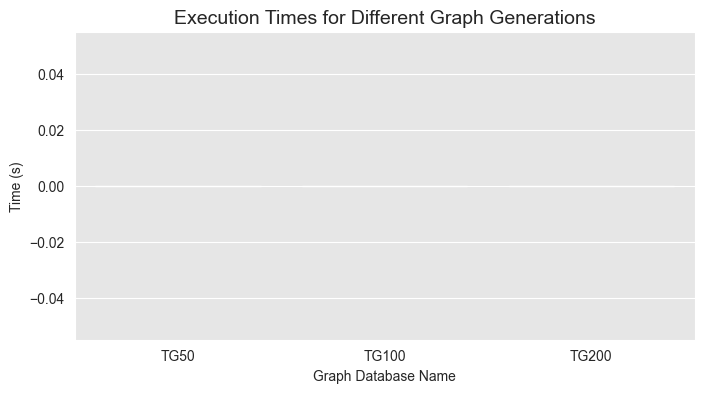

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=db.create_execution_times.keys(), y=db.create_execution_times.values(), ax=ax)
ax.set_title('Execution Times for Different Graph Generations', fontsize=14)
ax.set(xlabel='Graph Database Name', ylabel='Time (s)')

### Constraints
- The `available_terminals` property of a `CUSTOMER` does not necessarily reflect the `TERMINAL` nodes to which the customer is connected. This property only demonstrates the terminals located in the specified radius of the customer (in a 100 by 100 grid), and are accessible by the customer. Then, to create the graph, these terminals are randomly selected, hence they might not reflect all the connected edges. In addition, since this property holds a list, it might explode when the number of terminals in the radius increases. The property does not add any value to our analysis, so we can discard it from the domain.